# Meta-task PushWorld Training


In [ ]:
# WandB run: https://wandb.ai/kimyoungjin-nus/PushWorld/runs/e37dloir/overview

In [1]:
# Install if needed
!pip install "xminigrid[baselines] @ git+https://github.com/jugheadjones10/xland-minigrid.git"

  Cloning https://github.com/jugheadjones10/xland-minigrid.git to /tmp/pip-install-xpyc_wd5/xminigrid_dd6a463b94d449a189e6ade3ce046d01
  Running command git clone --filter=blob:none --quiet https://github.com/jugheadjones10/xland-minigrid.git /tmp/pip-install-xpyc_wd5/xminigrid_dd6a463b94d449a189e6ade3ce046d01
  Resolved https://github.com/jugheadjones10/xland-minigrid.git to commit 8a1409cba5986d9da42d342a4422cab52a97941e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.5/365.5 kB 27.9 MB/s eta 0:00:00
  Created wheel for xminigrid: filename=xminigrid-0.0.1-py3-none-any.whl size=84334 sha256=042e9c5dd2ea709a35273b2c99774b104d750e2edcc6c9d4771bd4f80bdbd950
  

In [2]:
import os
import shutil
import time  # noqa
import os  # noqa
import math  # noqa
from typing import TypedDict, Optional, Literal  # noqa
import numpy as np  # noqa
import importlib  # noqa
import os  # noqa

import jax  # noqa
import jax.numpy as jnp  # noqa
import jax.tree_util as jtu  # noqa
import flax  # noqa
import flax.linen as nn  # noqa
from flax.training import orbax_utils  # noqa
import distrax  # noqa
import orbax  # noqa
import optax  # noqa
import imageio  # noqa
import wandb  # noqa
import matplotlib.pyplot as plt  # noqa

from flax import struct  # noqa
from flax.typing import Dtype  # noqa
from flax.linen.dtypes import promote_dtype  # noqa
from flax.linen.initializers import glorot_normal, orthogonal, zeros_init  # noqa
from flax.training.train_state import TrainState  # noqa
from flax.jax_utils import replicate, unreplicate  # noqa
from dataclasses import asdict, dataclass  # noqa
from functools import partial  # noqa

import xminigrid.envs.pushworld as pushworld
from xminigrid.envs.pushworld.benchmarks import Benchmark, BenchmarkAll
from xminigrid.envs.pushworld.constants import Tiles, NUM_TILES, SUCCESS_REWARD
from xminigrid.envs.pushworld.environment import Environment, EnvParams, EnvParamsT
from xminigrid.envs.pushworld.envs.single_task_pushworld import (
    SingleTaskPushWorldEnvironment,
    SingleTaskPushWorldEnvParams,
)
from xminigrid.envs.pushworld.envs.meta_task_pushworld import MetaTaskPushWorldEnvironment

# Import level 0 "all" environments
from xminigrid.envs.pushworld.envs.single_task_all_pushworld import SingleTaskPushWorldEnvironmentAll
from xminigrid.envs.pushworld.envs.meta_task_all_pushworld import MetaTaskPushWorldEnvironmentAll
from xminigrid.envs.pushworld.scripts.upload import encode_puzzle
from xminigrid.envs.pushworld.wrappers import GoalObservationWrapper, GymAutoResetWrapper, Wrapper
from xminigrid.envs.pushworld.types import State, TimeStep, StepType, EnvCarry, PushWorldPuzzle, PushWorldPuzzleAll
from xminigrid.envs.pushworld.grid import get_obs_from_puzzle
from IPython.display import Video, HTML, display

2025-07-24 07:55:10.066137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753343710.260892      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753343710.314235      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO:2025-07-24 07:55:24,740:jax._src.xla_bridge:924: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-07-24 07:55:24,752:jax._src.xla_bridge:924: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


## Networks


In [3]:
# Model adapted from minigrid baselines:
# https://github.com/lcswillems/rl-starter-files/blob/master/model.py


class GRU(nn.Module):
    hidden_dim: int
    dtype: Optional[Dtype] = None
    param_dtype: Dtype = jnp.float32

    @nn.compact
    def __call__(self, xs, init_state):
        seq_len, input_dim = xs.shape
        # this init might not be optimal, for example bias for reset gate should be -1 (for now ok)
        Wi = self.param("Wi", glorot_normal(in_axis=1, out_axis=0), (self.hidden_dim * 3, input_dim), self.param_dtype)
        Wh = self.param("Wh", orthogonal(column_axis=0), (self.hidden_dim * 3, self.hidden_dim), self.param_dtype)
        bi = self.param("bi", zeros_init(), (self.hidden_dim * 3,), self.param_dtype)
        bn = self.param("bn", zeros_init(), (self.hidden_dim,), self.param_dtype)

        def _step_fn(h, x):
            igates = jnp.split(Wi @ x + bi, 3)
            hgates = jnp.split(Wh @ h, 3)

            reset = nn.sigmoid(igates[0] + hgates[0])
            update = nn.sigmoid(igates[1] + hgates[1])
            new = nn.tanh(igates[2] + reset * (hgates[2] + bn))
            next_h = (1 - update) * new + update * h

            return next_h, next_h

        # cast to the computation dtype
        xs, init_state, Wi, Wh, bi, bn = promote_dtype(xs, init_state, Wi, Wh, bi, bn, dtype=self.dtype)

        last_state, all_states = jax.lax.scan(_step_fn, init=init_state, xs=xs)
        return all_states, last_state


class RNNModel(nn.Module):
    hidden_dim: int
    num_layers: int
    dtype: Optional[Dtype] = None
    param_dtype: Dtype = jnp.float32

    @nn.compact
    def __call__(self, xs, init_state):
        # xs: [seq_len, input_dim]
        # init_state: [num_layers, hidden_dim]
        outs, states = [], []
        for layer in range(self.num_layers):
            xs, state = GRU(self.hidden_dim, self.dtype, self.param_dtype)(xs, init_state[layer])
            outs.append(xs)
            states.append(state)

        # sum outputs from all layers, kinda like in ResNet
        return jnp.array(outs).sum(0), jnp.array(states)


BatchedRNNModel = flax.linen.vmap(
    RNNModel, variable_axes={"params": None}, split_rngs={"params": False}, axis_name="batch"
)


class EmbeddingEncoder(nn.Module):
    emb_dim: int = 16
    dtype: Optional[Dtype] = None
    param_dtype: Dtype = jnp.float32

    @nn.compact
    def __call__(self, img):
        entity_emb = nn.Embed(NUM_TILES, self.emb_dim, self.dtype, self.param_dtype)

        # [..., channels]
        img_emb = entity_emb(img[..., 0])
        return img_emb


class ActorCriticInput(TypedDict):
    obs_img: jax.Array
    obs_goal: jax.Array
    prev_action: jax.Array
    prev_reward: jax.Array


class ActorCriticRNN(nn.Module):
    num_actions: int
    obs_emb_dim: int = 16
    action_emb_dim: int = 16
    rnn_hidden_dim: int = 64
    rnn_num_layers: int = 1
    head_hidden_dim: int = 64
    img_obs: bool = False
    dtype: Optional[Dtype] = None
    param_dtype: Dtype = jnp.float32

    @nn.compact
    def __call__(self, inputs: ActorCriticInput, hidden: jax.Array) -> tuple[distrax.Categorical, jax.Array, jax.Array]:
        B, S = inputs["obs_img"].shape[:2]

        # encoder from https://github.com/lcswillems/rl-starter-files/blob/master/model.py
        if self.img_obs:
            img_encoder = nn.Sequential(
                [
                    nn.Conv(
                        16,
                        (3, 3),
                        strides=2,
                        padding="VALID",
                        kernel_init=orthogonal(math.sqrt(2)),
                        dtype=self.dtype,
                        param_dtype=self.param_dtype,
                    ),
                    nn.relu,
                    nn.Conv(
                        32,
                        (3, 3),
                        strides=2,
                        padding="VALID",
                        kernel_init=orthogonal(math.sqrt(2)),
                        dtype=self.dtype,
                        param_dtype=self.param_dtype,
                    ),
                    nn.relu,
                    nn.Conv(
                        32,
                        (3, 3),
                        strides=2,
                        padding="VALID",
                        kernel_init=orthogonal(math.sqrt(2)),
                        dtype=self.dtype,
                        param_dtype=self.param_dtype,
                    ),
                    nn.relu,
                    nn.Conv(
                        32,
                        (3, 3),
                        strides=2,
                        padding="VALID",
                        kernel_init=orthogonal(math.sqrt(2)),
                        dtype=self.dtype,
                        param_dtype=self.param_dtype,
                    ),
                ]
            )
        else:
            img_encoder = nn.Sequential(
                [
                    # For small dims nn.Embed is extremely slow in bf16, so we leave everything in default dtypes
                    EmbeddingEncoder(emb_dim=self.obs_emb_dim),
                    nn.Conv(
                        16,
                        (2, 2),
                        padding="VALID",
                        kernel_init=orthogonal(math.sqrt(2)),
                        dtype=self.dtype,
                        param_dtype=self.param_dtype,
                    ),
                    nn.relu,
                    nn.Conv(
                        32,
                        (2, 2),
                        padding="VALID",
                        kernel_init=orthogonal(math.sqrt(2)),
                        dtype=self.dtype,
                        param_dtype=self.param_dtype,
                    ),
                    nn.relu,
                    nn.Conv(
                        64,
                        (2, 2),
                        padding="VALID",
                        kernel_init=orthogonal(math.sqrt(2)),
                        dtype=self.dtype,
                        param_dtype=self.param_dtype,
                    ),
                    nn.relu,
                ]
            )
        action_encoder = nn.Embed(self.num_actions, self.action_emb_dim)
        goal_encoder = nn.Dense(self.action_emb_dim, dtype=self.dtype, param_dtype=self.param_dtype)

        rnn_core = BatchedRNNModel(
            self.rnn_hidden_dim, self.rnn_num_layers, dtype=self.dtype, param_dtype=self.param_dtype
        )
        actor = nn.Sequential(
            [
                nn.Dense(
                    self.head_hidden_dim, kernel_init=orthogonal(2), dtype=self.dtype, param_dtype=self.param_dtype
                ),
                nn.tanh,
                nn.Dense(
                    self.num_actions, kernel_init=orthogonal(0.01), dtype=self.dtype, param_dtype=self.param_dtype
                ),
            ]
        )
        critic = nn.Sequential(
            [
                nn.Dense(
                    self.head_hidden_dim, kernel_init=orthogonal(2), dtype=self.dtype, param_dtype=self.param_dtype
                ),
                nn.tanh,
                nn.Dense(1, kernel_init=orthogonal(1.0), dtype=self.dtype, param_dtype=self.param_dtype),
            ]
        )

        # [batch_size, seq_len, ...]
        obs_emb = img_encoder(inputs["obs_img"].astype(jnp.int32)).reshape(B, S, -1)
        goal_emb = goal_encoder(inputs["obs_goal"])
        act_emb = action_encoder(inputs["prev_action"])

        # [batch_size, seq_len, hidden_dim + 2 * act_emb_dim + 1]
        out = jnp.concatenate([obs_emb, goal_emb, act_emb, inputs["prev_reward"][..., None]], axis=-1)

        # core networks
        out, new_hidden = rnn_core(out, hidden)

        # casting to full precision for the loss, as softmax/log_softmax
        # (inside Categorical) is not stable in bf16
        logits = actor(out).astype(jnp.float32)

        dist = distrax.Categorical(logits=logits)
        values = critic(out)

        return dist, jnp.squeeze(values, axis=-1), new_hidden

    def initialize_carry(self, batch_size):
        return jnp.zeros((batch_size, self.rnn_num_layers, self.rnn_hidden_dim), dtype=self.dtype)

## Utils


In [4]:
# utilities for PPO training and evaluation


# Training stuff
class Transition(struct.PyTreeNode):
    done: jax.Array
    action: jax.Array
    value: jax.Array
    reward: jax.Array
    log_prob: jax.Array
    # for obs
    obs: jax.Array
    goal: jax.Array
    # for rnn policy
    prev_action: jax.Array
    prev_reward: jax.Array


def calculate_gae(
    transitions: Transition,
    last_val: jax.Array,
    gamma: float,
    gae_lambda: float,
) -> tuple[jax.Array, jax.Array]:
    # single iteration for the loop
    def _get_advantages(gae_and_next_value, transition):
        gae, next_value = gae_and_next_value
        delta = transition.reward + gamma * next_value * (1 - transition.done) - transition.value
        gae = delta + gamma * gae_lambda * (1 - transition.done) * gae
        return (gae, transition.value), gae

    _, advantages = jax.lax.scan(
        _get_advantages,
        (jnp.zeros_like(last_val), last_val),
        transitions,
        reverse=True,
    )
    # advantages and values (Q)
    return advantages, advantages + transitions.value


def ppo_update_networks(
    train_state: TrainState,
    transitions: Transition,
    init_hstate: jax.Array,
    advantages: jax.Array,
    targets: jax.Array,
    clip_eps: float,
    vf_coef: float,
    ent_coef: float,
):
    # NORMALIZE ADVANTAGES
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    def _loss_fn(params):
        # RERUN NETWORK
        dist, value, _ = train_state.apply_fn(
            params,
            {
                # [batch_size, seq_len, ...]
                "obs_img": transitions.obs,
                "obs_goal": transitions.goal,
                "prev_action": transitions.prev_action,
                "prev_reward": transitions.prev_reward,
            },
            init_hstate,
        )
        log_prob = dist.log_prob(transitions.action)

        # CALCULATE VALUE LOSS
        value_pred_clipped = transitions.value + (value - transitions.value).clip(-clip_eps, clip_eps)
        value_loss = jnp.square(value - targets)
        value_loss_clipped = jnp.square(value_pred_clipped - targets)
        value_loss = 0.5 * jnp.maximum(value_loss, value_loss_clipped).mean()

        # TODO: ablate this!
        # value_loss = jnp.square(value - targets).mean()

        # CALCULATE ACTOR LOSS
        ratio = jnp.exp(log_prob - transitions.log_prob)
        actor_loss1 = advantages * ratio
        actor_loss2 = advantages * jnp.clip(ratio, 1.0 - clip_eps, 1.0 + clip_eps)
        actor_loss = -jnp.minimum(actor_loss1, actor_loss2).mean()
        entropy = dist.entropy().mean()

        total_loss = actor_loss + vf_coef * value_loss - ent_coef * entropy
        return total_loss, (value_loss, actor_loss, entropy)

    (loss, (vloss, aloss, entropy)), grads = jax.value_and_grad(_loss_fn, has_aux=True)(train_state.params)
    (loss, vloss, aloss, entropy, grads) = jax.lax.pmean((loss, vloss, aloss, entropy, grads), axis_name="devices")
    train_state = train_state.apply_gradients(grads=grads)
    update_info = {
        "total_loss": loss,
        "value_loss": vloss,
        "actor_loss": aloss,
        "entropy": entropy,
    }
    return train_state, update_info


# for evaluation (evaluate for N consecutive episodes, sum rewards)
# N=1 single task, N>1 for meta-RL
class RolloutStats(struct.PyTreeNode):
    reward: jax.Array = struct.field(default_factory=lambda: jnp.asarray(0.0))
    length: jax.Array = struct.field(default_factory=lambda: jnp.asarray(0))
    episodes: jax.Array = struct.field(default_factory=lambda: jnp.asarray(0))
    solved: jax.Array = struct.field(default_factory=lambda: jnp.asarray(0))


# for tracking per-episode statistics during meta-RL evaluation
class MetaRolloutStats(struct.PyTreeNode):
    episode_rewards: jax.Array  # Shape: [max_episodes] - reward for each episode
    episode_lengths: jax.Array  # Shape: [max_episodes] - length of each episode
    episode_solved: jax.Array  # Shape: [max_episodes] - whether each episode was solved
    total_reward: jax.Array  # Scalar - total reward across all episodes
    num_episodes_completed: jax.Array  # Scalar - number of episodes actually completed


def rollout(
    rng: jax.Array,
    env: Environment,
    env_params: EnvParams,
    eval_puzzle: PushWorldPuzzle,
    train_state: TrainState,
    init_hstate: jax.Array,
    num_consecutive_episodes: int = 1,
) -> RolloutStats:
    def _cond_fn(carry):
        rng, stats, timestep, prev_action, prev_reward, hstate = carry
        return jnp.less(stats.episodes, num_consecutive_episodes)

    def _body_fn(carry):
        rng, stats, timestep, prev_action, prev_reward, hstate = carry

        rng, _rng = jax.random.split(rng)
        dist, _, hstate = train_state.apply_fn(
            train_state.params,
            {
                # We add single channel dimension to end of obs_img
                "obs_img": timestep.observation["img"][None, None, ...],
                "obs_goal": timestep.observation["goal"][None, None, ...],
                "prev_action": prev_action[None, None, ...],
                "prev_reward": prev_reward[None, None, ...],
            },
            hstate,
        )
        action = dist.sample(seed=_rng).squeeze()
        timestep = env.step(env_params, timestep, action)

        solved_flag = ((timestep.reward == SUCCESS_REWARD) & (timestep.last() == 1)).astype(jnp.int32)
        stats = stats.replace(
            reward=stats.reward + timestep.reward,
            length=stats.length + 1,
            episodes=stats.episodes + timestep.last(),
            solved=solved_flag,
        )
        carry = (rng, stats, timestep, action, timestep.reward, hstate)
        return carry

    env_params = env_params.replace(puzzle=eval_puzzle)
    timestep = env.eval_reset(env_params, rng)
    prev_action = jnp.asarray(0)
    prev_reward = jnp.asarray(0)
    init_carry = (rng, RolloutStats(), timestep, prev_action, prev_reward, init_hstate)

    final_carry = jax.lax.while_loop(_cond_fn, _body_fn, init_val=init_carry)
    return final_carry[1]


def meta_rollout(
    rng: jax.Array,
    env: Environment,
    env_params: EnvParams,
    eval_puzzle: PushWorldPuzzle,
    train_state: TrainState,
    init_hstate: jax.Array,
    num_consecutive_episodes: int = 1,
) -> MetaRolloutStats:
    """Rollout that tracks statistics for each individual episode."""

    def _cond_fn(carry):
        rng, stats, timestep, prev_action, prev_reward, hstate, current_episode_reward, current_episode_length = carry
        return jnp.less(stats.num_episodes_completed, num_consecutive_episodes)

    def _body_fn(carry):
        rng, stats, timestep, prev_action, prev_reward, hstate, current_episode_reward, current_episode_length = carry

        rng, _rng = jax.random.split(rng)
        dist, _, hstate = train_state.apply_fn(
            train_state.params,
            {
                # We add single channel dimension to end of obs_img
                "obs_img": timestep.observation["img"][None, None, ...],
                "obs_goal": timestep.observation["goal"][None, None, ...],
                "prev_action": prev_action[None, None, ...],
                "prev_reward": prev_reward[None, None, ...],
            },
            hstate,
        )
        action = dist.sample(seed=_rng).squeeze()
        timestep = env.step(env_params, timestep, action)

        # Update current episode accumulators
        current_episode_reward = current_episode_reward + timestep.reward
        current_episode_length = current_episode_length + 1

        # Check if episode ended
        episode_ended = timestep.last()
        solved_flag = ((timestep.reward == SUCCESS_REWARD) & (episode_ended == 1)).astype(jnp.int32)

        # When episode ends, store the episode stats
        episode_idx = stats.num_episodes_completed
        new_episode_rewards = stats.episode_rewards.at[episode_idx].set(
            jnp.where(episode_ended, current_episode_reward, stats.episode_rewards[episode_idx])
        )
        new_episode_lengths = stats.episode_lengths.at[episode_idx].set(
            jnp.where(episode_ended, current_episode_length, stats.episode_lengths[episode_idx])
        )
        new_episode_solved = stats.episode_solved.at[episode_idx].set(
            jnp.where(episode_ended, solved_flag, stats.episode_solved[episode_idx])
        )

        # Update stats
        stats = stats.replace(
            episode_rewards=new_episode_rewards,
            episode_lengths=new_episode_lengths,
            episode_solved=new_episode_solved,
            total_reward=stats.total_reward + timestep.reward,
            num_episodes_completed=stats.num_episodes_completed + episode_ended,
        )

        # Reset episode accumulators when episode ends
        current_episode_reward = jnp.where(episode_ended, 0.0, current_episode_reward)
        current_episode_length = jnp.where(episode_ended, 0, current_episode_length)

        carry = (rng, stats, timestep, action, timestep.reward, hstate, current_episode_reward, current_episode_length)
        return carry

    # Initialize episode tracking arrays
    episode_rewards = jnp.zeros(num_consecutive_episodes)
    episode_lengths = jnp.zeros(num_consecutive_episodes, dtype=jnp.int32)
    episode_solved = jnp.zeros(num_consecutive_episodes, dtype=jnp.int32)

    initial_stats = MetaRolloutStats(
        episode_rewards=episode_rewards,
        episode_lengths=episode_lengths,
        episode_solved=episode_solved,
        total_reward=jnp.asarray(0.0),
        num_episodes_completed=jnp.asarray(0),
    )

    env_params = env_params.replace(puzzle=eval_puzzle)
    timestep = env.eval_reset(env_params, rng)
    prev_action = jnp.asarray(0)
    prev_reward = jnp.asarray(0)
    current_episode_reward = jnp.asarray(0.0)
    current_episode_length = jnp.asarray(0)

    init_carry = (
        rng,
        initial_stats,
        timestep,
        prev_action,
        prev_reward,
        init_hstate,
        current_episode_reward,
        current_episode_length,
    )

    final_carry = jax.lax.while_loop(_cond_fn, _body_fn, init_val=init_carry)
    return final_carry[1]

## Training


In [5]:
jax.config.update("jax_threefry_partitionable", True)


@dataclass
class TrainConfig:
    project: str = "PushWorld"
    group: str = "default"
    name: str = "meta-task-ppo"
    benchmark_id: str = "level0_mini"
    track: bool = False
    checkpoint_path: Optional[str] = None
    upload_model: bool = False

    train_test_same: bool = False
    num_train: Optional[int] = None
    num_test: Optional[int] = None

    img_obs: bool = False
    obs_emb_dim: int = 16
    action_emb_dim: int = 16
    rnn_hidden_dim: int = 1024
    rnn_num_layers: int = 1
    head_hidden_dim: int = 256
    enable_bf16: bool = False
    num_envs: int = 8192
    num_steps_per_env: int = 4096
    num_steps_per_update: int = 32
    update_epochs: int = 1
    num_minibatches: int = 16
    total_timesteps: int = 100_000_000
    lr: float = 0.001
    clip_eps: float = 0.2
    gamma: float = 0.99
    gae_lambda: float = 0.95
    ent_coef: float = 0.01
    vf_coef: float = 0.5
    max_grad_norm: float = 0.5
    eval_num_envs: int = 512
    eval_num_episodes: int = 10
    eval_seed: int = 42
    train_seed: int = 42
    puzzle_seed: int = 42
    checkpoint_path: Optional[str] = None

    def __post_init__(self):
        num_devices = jax.local_device_count()
        self.num_envs_per_device = self.num_envs // num_devices
        self.total_timesteps_per_device = self.total_timesteps // num_devices
        self.eval_num_envs_per_device = self.eval_num_envs // num_devices
        assert self.num_envs % num_devices == 0
        self.num_meta_updates = round(
            self.total_timesteps_per_device / (self.num_envs_per_device * self.num_steps_per_env)
        )
        self.num_inner_updates = self.num_steps_per_env // self.num_steps_per_update
        assert self.num_steps_per_env % self.num_steps_per_update == 0
        print(f"Num devices: {num_devices}, Num meta updates: {self.num_meta_updates}")


def make_states(config: TrainConfig):
    # for learning rage scheduling
    def linear_schedule(count):
        total_inner_updates = config.num_minibatches * config.update_epochs * config.num_inner_updates
        frac = 1.0 - (count // total_inner_updates) / config.num_meta_updates
        return config.lr * frac

    env = MetaTaskPushWorldEnvironment()
    env_params = env.default_params()
    env = GymAutoResetWrapper(env)
    env = GoalObservationWrapper(env)

    benchmark = pushworld.load_benchmark(config.benchmark_id)

    puzzle_rng = jax.random.key(config.puzzle_seed)
    train_rng, test_rng = jax.random.split(puzzle_rng)

    if config.num_train is not None:
        assert config.num_train <= benchmark.num_train_puzzles(), (
            "num_train is larger than num train available in benchmark"
        )
        perm = jax.random.permutation(train_rng, benchmark.num_train_puzzles())
        idxs = perm[: config.num_train]
        benchmark = benchmark.replace(train_puzzles=benchmark.train_puzzles[idxs])
    else:
        config.num_train = benchmark.num_train_puzzles()

    if config.num_test is not None:
        assert config.num_test <= benchmark.num_test_puzzles(), (
            "num_test is larger than num test available in benchmark"
        )
        perm = jax.random.permutation(test_rng, benchmark.num_test_puzzles())
        idxs = perm[: config.num_test]
        benchmark = benchmark.replace(test_puzzles=benchmark.test_puzzles[idxs])
    else:
        config.num_test = benchmark.num_test_puzzles()

    if config.train_test_same:
        benchmark = benchmark.replace(test_puzzles=benchmark.train_puzzles)
        config.num_test = config.num_train

    rng = jax.random.key(config.train_seed)
    rng, _rng = jax.random.split(rng)

    network = ActorCriticRNN(
        num_actions=env.num_actions(env_params),
        obs_emb_dim=config.obs_emb_dim,
        action_emb_dim=config.action_emb_dim,
        rnn_hidden_dim=config.rnn_hidden_dim,
        rnn_num_layers=config.rnn_num_layers,
        head_hidden_dim=config.head_hidden_dim,
        img_obs=config.img_obs,
        dtype=jnp.bfloat16 if config.enable_bf16 else None,
    )
    shapes = env.observation_shape(env_params)

    init_obs = {
        # We add single channel dimension to end of obs_img
        "obs_img": jnp.zeros((config.num_envs_per_device, 1, *shapes["img"])),
        "obs_goal": jnp.zeros((config.num_envs_per_device, 1, shapes["goal"])),
        "prev_action": jnp.zeros((config.num_envs_per_device, 1), dtype=jnp.int32),
        "prev_reward": jnp.zeros((config.num_envs_per_device, 1)),
    }
    init_hstate = network.initialize_carry(batch_size=config.num_envs_per_device)

    network_params = network.init(_rng, init_obs, init_hstate)
    tx = optax.chain(
        optax.clip_by_global_norm(config.max_grad_norm),
        optax.inject_hyperparams(optax.adam)(learning_rate=linear_schedule, eps=1e-8),  # eps=1e-5
    )
    train_state = TrainState.create(apply_fn=network.apply, params=network_params, tx=tx)

    return rng, env, env_params, benchmark, init_hstate, train_state


def make_train(
    env: Environment,
    env_params: EnvParams,
    benchmark: Benchmark,
    config: TrainConfig,
):
    @partial(jax.pmap, axis_name="devices")
    def train(
        rng: jax.Array,
        train_state: TrainState,
        init_hstate: jax.Array,
    ):
        eval_hstate = init_hstate[0][None]

        # META TRAIN LOOP
        def _meta_step(meta_state, _):
            rng, train_state = meta_state

            rng, _rng1, _rng2 = jax.random.split(rng, num=3)
            puzzle_rng = jax.random.split(_rng1, num=config.num_envs_per_device)
            reset_rng = jax.random.split(_rng2, num=config.num_envs_per_device)

            puzzles = jax.vmap(benchmark.sample_puzzle, in_axes=(0, None))(puzzle_rng, "train")
            meta_env_params = env_params.replace(puzzle=puzzles)

            timestep = jax.vmap(env.reset, in_axes=(0, 0))(meta_env_params, reset_rng)
            prev_action = jnp.zeros(config.num_envs_per_device, dtype=jnp.int32)
            prev_reward = jnp.zeros(config.num_envs_per_device)

            # INNER TRAIN LOOP
            def _update_step(runner_state, _):
                # COLLECT TRAJECTORIES
                def _env_step(runner_state, _):
                    rng, train_state, prev_timestep, prev_action, prev_reward, prev_hstate = runner_state

                    rng, _rng = jax.random.split(rng)
                    dist, value, hstate = train_state.apply_fn(
                        train_state.params,
                        {
                            # [batch_size, seq_len=1, ...]
                            # We add single channel dimension to end of obs_img
                            "obs_img": prev_timestep.observation["img"][:, None],
                            "obs_goal": prev_timestep.observation["goal"][:, None],
                            "prev_action": prev_action[:, None],
                            "prev_reward": prev_reward[:, None],
                        },
                        prev_hstate,
                    )
                    action, log_prob = dist.sample_and_log_prob(seed=_rng)
                    action, value, log_prob = action.squeeze(1), value.squeeze(1), log_prob.squeeze(1)

                    timestep = jax.vmap(env.step, in_axes=0)(meta_env_params, prev_timestep, action)
                    transition = Transition(
                        # ATTENTION: done is always false, as we optimize for entire meta-rollout
                        done=jnp.zeros_like(timestep.last()),
                        action=action,
                        value=value,
                        reward=timestep.reward,
                        log_prob=log_prob,
                        obs=prev_timestep.observation["img"],
                        goal=prev_timestep.observation["goal"],
                        prev_action=prev_action,
                        prev_reward=prev_reward,
                    )
                    runner_state = (rng, train_state, timestep, action, timestep.reward, hstate)
                    return runner_state, transition

                initial_hstate = runner_state[-1]
                runner_state, transitions = jax.lax.scan(_env_step, runner_state, None, config.num_steps_per_update)

                rng, train_state, timestep, prev_action, prev_reward, hstate = runner_state
                _, last_val, _ = train_state.apply_fn(
                    train_state.params,
                    {
                        # We add single channel dimension to end of obs_img
                        "obs_img": timestep.observation["img"][:, None],
                        "obs_goal": timestep.observation["goal"][:, None],
                        "prev_action": prev_action[:, None],
                        "prev_reward": prev_reward[:, None],
                    },
                    hstate,
                )
                advantages, targets = calculate_gae(transitions, last_val.squeeze(1), config.gamma, config.gae_lambda)

                # UPDATE NETWORK
                def _update_epoch(update_state, _):
                    def _update_minbatch(train_state, batch_info):
                        init_hstate, transitions, advantages, targets = batch_info
                        new_train_state, update_info = ppo_update_networks(
                            train_state=train_state,
                            transitions=transitions,
                            init_hstate=init_hstate.squeeze(1),
                            advantages=advantages,
                            targets=targets,
                            clip_eps=config.clip_eps,
                            vf_coef=config.vf_coef,
                            ent_coef=config.ent_coef,
                        )
                        return new_train_state, update_info

                    rng, train_state, init_hstate, transitions, advantages, targets = update_state

                    rng, _rng = jax.random.split(rng)
                    permutation = jax.random.permutation(_rng, config.num_envs_per_device)
                    batch = (init_hstate, transitions, advantages, targets)
                    batch = jtu.tree_map(lambda x: x.swapaxes(0, 1), batch)

                    shuffled_batch = jtu.tree_map(lambda x: jnp.take(x, permutation, axis=0), batch)
                    minibatches = jtu.tree_map(
                        lambda x: jnp.reshape(x, (config.num_minibatches, -1) + x.shape[1:]), shuffled_batch
                    )
                    train_state, update_info = jax.lax.scan(_update_minbatch, train_state, minibatches)

                    update_state = (rng, train_state, init_hstate, transitions, advantages, targets)
                    return update_state, update_info

                update_state = (rng, train_state, initial_hstate[None, :], transitions, advantages, targets)
                update_state, loss_info = jax.lax.scan(_update_epoch, update_state, None, config.update_epochs)
                rng, train_state = update_state[:2]

                loss_info = jtu.tree_map(lambda x: x.mean(-1).mean(-1), loss_info)
                runner_state = (rng, train_state, timestep, prev_action, prev_reward, hstate)
                return runner_state, loss_info

            runner_state = (rng, train_state, timestep, prev_action, prev_reward, init_hstate)
            runner_state, loss_info = jax.lax.scan(_update_step, runner_state, None, config.num_inner_updates)
            rng, train_state = runner_state[:2]

            eval_reset_rng = jax.random.key(config.eval_seed)
            eval_test_rng, eval_train_rng = jax.random.split(eval_reset_rng)
            assert config.num_test is not None, "num_test must be set for evaluation"
            assert config.num_train is not None, "num_train must be set for evaluation"

            eval_test_reset_rng = jax.random.split(eval_test_rng, num=config.num_test)
            eval_test_puzzles = benchmark.get_test_puzzles()
            eval_test_stats = jax.vmap(meta_rollout, in_axes=(0, None, None, 0, None, None, None))(
                eval_test_reset_rng,
                env,
                meta_env_params,
                eval_test_puzzles,
                train_state,
                eval_hstate,
                config.eval_num_episodes,
            )
            eval_test_stats = jax.lax.pmean(eval_test_stats, axis_name="devices")

            eval_train_reset_rng = jax.random.split(eval_train_rng, num=config.num_train)
            eval_train_puzzles = benchmark.get_train_puzzles()
            eval_train_stats = jax.vmap(meta_rollout, in_axes=(0, None, None, 0, None, None, None))(
                eval_train_reset_rng,
                env,
                meta_env_params,
                eval_train_puzzles,
                train_state,
                eval_hstate,
                config.eval_num_episodes,
            )
            eval_train_stats = jax.lax.pmean(eval_train_stats, axis_name="devices")

            loss_info = jtu.tree_map(lambda x: x.mean(-1), loss_info)
            loss_info.update(
                {
                    # Originally we divided returns_mean by config.eval_num_episodes, but we realized
                    # that it is more intuitive to think about the cumulative returns over the whole meta-episode.
                    "eval_test/returns_mean": eval_test_stats.total_reward.mean(),
                    "eval_train/returns_mean_train": eval_train_stats.total_reward.mean(),
                    "eval_test/returns_median": jnp.median(eval_test_stats.total_reward),
                    "eval_test/returns_20percentile": jnp.percentile(eval_test_stats.total_reward, q=20),
                    # Our definition of solved is whether the agent solves the last trial in the meta-episode.
                    "eval_test/solved_percentage": eval_test_stats.episode_solved[:, -1].mean(),
                    "eval_train/solved_percentage_train": eval_train_stats.episode_solved[:, -1].mean(),
                    "eval_test/lengths": eval_test_stats.episode_lengths.mean(),
                    "eval_test/lengths_20percentile": jnp.percentile(eval_test_stats.episode_lengths, q=20),
                    "lr": train_state.opt_state[-1].hyperparams["learning_rate"],
                    # Store episode arrays - we'll convert to individual metrics outside JIT
                    "eval_test/episode_rewards": eval_test_stats.episode_rewards.mean(axis=0),
                    "eval_test/episode_solved_rates": eval_test_stats.episode_solved.mean(axis=0),
                    "eval_train/episode_rewards": eval_train_stats.episode_rewards.mean(axis=0),
                    "eval_train/episode_solved_rates": eval_train_stats.episode_solved.mean(axis=0),
                }
            )

            meta_state = (rng, train_state)
            return meta_state, loss_info

        meta_state = (rng, train_state)
        meta_state, loss_info = jax.lax.scan(_meta_step, meta_state, None, config.num_meta_updates)
        return {"state": meta_state[-1], "loss_info": loss_info}

    return train


def train(config: TrainConfig):
    # removing existing checkpoints if any
    if config.checkpoint_path is not None and os.path.exists(config.checkpoint_path):
        shutil.rmtree(config.checkpoint_path)

    rng, env, env_params, benchmark, init_hstate, train_state = make_states(config)
    rng = jax.random.split(rng, num=jax.local_device_count())
    train_state = replicate(train_state, jax.local_devices())
    init_hstate = replicate(init_hstate, jax.local_devices())

    print("Compiling...")
    t = time.time()
    train_fn = make_train(env, env_params, benchmark, config)
    train_fn = train_fn.lower(rng, train_state, init_hstate).compile()
    elapsed_time = time.time() - t
    print(f"Done in {elapsed_time:.2f}s.")

    print("Training...")
    t = time.time()
    train_info = jax.block_until_ready(train_fn(rng, train_state, init_hstate))
    elapsed_time = time.time() - t
    print(f"Done in {elapsed_time:.2f}s.")

    return unreplicate(train_info), elapsed_time

## Processing


In [6]:
jax.config.update("jax_threefry_partitionable", True)


def processing(config: TrainConfig, train_info, elapsed_time):
    print("Logginig...")
    loss_info = train_info["loss_info"]

    if config.track or config.upload_model:
        run = wandb.init(
            project=config.project,
            group=config.group,
            name=config.name,
            config=asdict(config),
            save_code=True,
        )

    if config.track:
        total_transitions = 0

        # I want to manipulate episode_rewards and episode_solved_rates so that I generate
        # eval_num_episodes separate metrics, where each metric represents the returns or solved rate
        # for one episode in the meta-episode, over meta_updates.
        for episode_idx in range(config.eval_num_episodes):
            loss_info[f"eval_test/episode_rewards/{episode_idx}"] = loss_info["eval_test/episode_rewards"].swapaxes(
                0, 1
            )[episode_idx]
            loss_info[f"eval_test/episode_solved_rates/{episode_idx}"] = loss_info[
                "eval_test/episode_solved_rates"
            ].swapaxes(0, 1)[episode_idx]
            loss_info[f"eval_train/episode_rewards/{episode_idx}"] = loss_info["eval_train/episode_rewards"].swapaxes(
                0, 1
            )[episode_idx]
            loss_info[f"eval_train/episode_solved_rates/{episode_idx}"] = loss_info[
                "eval_train/episode_solved_rates"
            ].swapaxes(0, 1)[episode_idx]

        loss_info.pop("eval_test/episode_rewards")
        loss_info.pop("eval_test/episode_solved_rates")
        loss_info.pop("eval_train/episode_rewards")
        loss_info.pop("eval_train/episode_solved_rates")

        for i in range(config.num_meta_updates):
            total_transitions += config.num_steps_per_env * config.num_envs_per_device * jax.local_device_count()
            info = jtu.tree_map(lambda x: x[i].item(), loss_info)
            info["transitions"] = total_transitions
            wandb.log(info)

        run.summary["training_time"] = elapsed_time
        run.summary["steps_per_second"] = (config.total_timesteps_per_device * jax.local_device_count()) / elapsed_time

    if config.checkpoint_path is not None:
        checkpoint = {"config": asdict(config), "params": train_info["state"].params}
        orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
        save_args = orbax_utils.save_args_from_target(checkpoint)
        orbax_checkpointer.save(config.checkpoint_path, checkpoint, save_args=save_args)

        if config.upload_model:
            artifact = wandb.Artifact(
                name=f"model-checkpoint-{run.id}", type="model", description="Trained model checkpoint"
            )
            artifact.add_dir(config.checkpoint_path)  # Add entire checkpoint directory
            run.log_artifact(artifact)

    if config.track or config.upload_model:
        run.finish()

    print("Final test return: ", float(loss_info["eval_test/returns_mean"][-1]))
    print("Final train return: ", float(loss_info["eval_train/returns_mean_train"][-1]))
    print("Final test solve rate: ", float(loss_info["eval_test/solved_percentage"][-1]))
    print("Final train solve rate: ", float(loss_info["eval_train/solved_percentage_train"][-1]))

## Evaluation


In [7]:
def hex_to_rgb(hex_string: str):
    """Converts a standard 6-digit hex color into a tuple of decimal
    (red, green, blue) values."""
    return tuple(int(hex_string[i : i + 2], 16) for i in (0, 2, 4))


symbol_to_rgb = {
    0: hex_to_rgb("FFFFFF"),  # empty → white
    1: hex_to_rgb("00DC00"),  # agent → "00DC00"
    2: hex_to_rgb("469BFF"),  # movable → "469BFF"
    3: hex_to_rgb("DC0000"),  # movable_goal → "DC0000"
    4: hex_to_rgb("0A0A0A"),  # wall → "0A0A0A"
}


def text_to_rgb(goal_pos, grid):
    """grid: 2-D array of str, shape (H, W)"""
    h, w = grid.shape
    img = np.zeros((h, w, 3), dtype=np.uint8)
    for sym, rgb in symbol_to_rgb.items():
        mask = grid == sym
        img[mask] = rgb

    if grid[goal_pos[1], goal_pos[0]] == Tiles.EMPTY:
        img[goal_pos[1], goal_pos[0]] = hex_to_rgb("FF7F7F")  # light red

    # upscale (optional) so each tile is, say, 16×16 pixels
    img = np.kron(img, np.ones((64, 64, 1), dtype=np.uint8))
    return img


def text_to_rgb_all(observation: jax.Array):
    # I want you to render the observation into a grid
    # Observation is a jax.Array, shape (H, W, 8),
    # Where 8 is the number of channels.
    # Each channel represents a different object, which should have its own color.
    # This is the order of the channels:
    # channels.append(create_channel(state.a))  # agent
    # channels.append(create_channel(state.m1))  # movable 1
    # channels.append(create_channel(state.m2))  # movable 2
    # channels.append(create_channel(state.m3))  # movable 3
    # channels.append(create_channel(state.m4))  # movable 4
    # channels.append(create_channel(puzzle.g1))  # goal 1
    # channels.append(create_channel(puzzle.g2))  # goal 2
    # channels.append(create_channel(puzzle.w))  # walls

    # Movables that have associated goals should be given the "movable_goal" color,
    # movables that do not should just be given the "movable" color.

    # Convert to numpy for easier processing
    obs_np = np.array(observation)
    h, w = obs_np.shape[:2]

    # Create RGB image initialized to white (empty spaces)
    rgb_img = np.zeros((h, w, 3), dtype=np.uint8)
    rgb_img.fill(255)  # white background

    # Channel indices
    AGENT_CH = 0
    M1_CH, M2_CH, M3_CH, M4_CH = 1, 2, 3, 4
    G1_CH, G2_CH = 5, 6
    WALL_CH = 7

    # Extract individual channels
    agent = obs_np[:, :, AGENT_CH]
    m1 = obs_np[:, :, M1_CH]
    m2 = obs_np[:, :, M2_CH]
    m3 = obs_np[:, :, M3_CH]
    m4 = obs_np[:, :, M4_CH]
    g1 = obs_np[:, :, G1_CH]
    g2 = obs_np[:, :, G2_CH]
    walls = obs_np[:, :, WALL_CH]

    # Render walls first (bottom layer)
    wall_mask = walls > 0
    rgb_img[wall_mask] = symbol_to_rgb[4]  # black

    # Render goals (light red for empty goals)
    g1_mask = g1 > 0
    g2_mask = g2 > 0
    rgb_img[g1_mask] = hex_to_rgb("FF7F7F")  # light red
    rgb_img[g2_mask] = hex_to_rgb("FF7F7F")  # light red

    # Render movables with appropriate colors
    # Goal-movable pairing is dynamic based on which goals exist:
    # - If only g1 exists: m1 is the goal movable, m2/m3/m4 are regular movables
    # - If both g1 and g2 exist: m1 and m2 are goal movables, m3/m4 are regular movables

    # Check which goals exist
    g1_exists = np.any(g1_mask)
    g2_exists = np.any(g2_mask)

    # m1: movable_goal color if on g1. g1 is guaranteed to always exist.
    m1_mask = m1 > 0
    rgb_img[m1_mask] = symbol_to_rgb[3]  # movable_goal (red)

    # m2: movable_goal color if on g2 (when g2 exists), otherwise movable color
    m2_mask = m2 > 0
    if g2_exists:
        rgb_img[m2_mask] = symbol_to_rgb[3]  # movable_goal (red)
    else:
        rgb_img[m2_mask] = symbol_to_rgb[2]  # movable (blue)

    # m3 and m4: always regular movable color (no associated goals)
    m3_mask = m3 > 0
    m4_mask = m4 > 0
    rgb_img[m3_mask] = symbol_to_rgb[2]  # movable (blue)
    rgb_img[m4_mask] = symbol_to_rgb[2]  # movable (blue)

    # Render agent on top
    agent_mask = agent > 0
    rgb_img[agent_mask] = symbol_to_rgb[1]  # agent (green)

    # Upscale for better visibility (64x64 pixels per tile)
    upscaled_img = np.kron(rgb_img, np.ones((64, 64, 1), dtype=np.uint8))

    return upscaled_img


def fetch_model_from_wandb(
    project: str,
    run_id: str,
    artifact_name: Optional[str] = None,
    download_path: str = "./downloaded_checkpoints",
    entity: Optional[str] = None,
):
    """
    Fetch model parameters from a WandB artifact.

    Args:
        project: WandB project name
        run_id: WandB run ID
        artifact_name: Specific artifact name (if None, uses f"model-checkpoint-{run_id}")
        download_path: Local path to download the artifact
        entity: WandB entity/username (if None, uses default)

    Returns:
        Model parameters from the checkpoint
    """

    # Initialize wandb in offline mode to avoid creating a new run
    if entity:
        wandb.init(project=project, entity=entity, mode="offline")
    else:
        wandb.init(project=project, mode="offline")

    try:
        # Construct artifact name if not provided
        if artifact_name is None:
            artifact_name = f"model-checkpoint-{run_id}:latest"
        elif ":latest" not in artifact_name and ":v" not in artifact_name:
            artifact_name = f"{artifact_name}:latest"

        print(f"Fetching artifact: {artifact_name}")

        # Download the artifact
        artifact = wandb.use_artifact(artifact_name)
        artifact_dir = artifact.download(root=download_path)

        print(f"Downloaded to: {artifact_dir}")

        # Load the checkpoint using orbax
        orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
        checkpoint = orbax_checkpointer.restore(artifact_dir)

        print("Successfully loaded checkpoint")

        return checkpoint["params"]

    except Exception as e:
        print(f"Error fetching model from WandB: {e}")
        raise
    finally:
        wandb.finish()

In [8]:
def evaluate_meta(train_info, config, puzzles, video_name, eval_seed):
    META_EPISODES = 10
    # We're only going to sample from test anyway
    benchmark = Benchmark(
        train_puzzles=puzzles,
        test_puzzles=puzzles,
    )

    # setup environment
    env = MetaTaskPushWorldEnvironment()
    env = GymAutoResetWrapper(env)
    env = GoalObservationWrapper(env)
    env_params = env.default_params()

    rng = jax.random.key(eval_seed)
    rng, _rng = jax.random.split(rng)

    puzzle = benchmark.sample_puzzle(_rng, "test")
    env_params = env_params.replace(puzzle=puzzle)

    # you can use train_state from the final state also
    # we just demo here how to do it if you loaded params from the checkpoint
    params = train_info["state"].params
    model = ActorCriticRNN(
        num_actions=env.num_actions(env_params),
        action_emb_dim=config.action_emb_dim,
        rnn_hidden_dim=config.rnn_hidden_dim,
        rnn_num_layers=config.rnn_num_layers,
        head_hidden_dim=config.head_hidden_dim,
        img_obs=config.img_obs,
    )

    # jitting all functions
    apply_fn, reset_fn, step_fn = jax.jit(model.apply), jax.jit(env.reset), jax.jit(env.step)

    # for logging
    total_reward, num_episodes = 0, 0
    rendered_imgs = []

    rng, _rng = jax.random.split(rng)

    # initial inputs
    hidden = model.initialize_carry(1)
    prev_reward = jnp.asarray(0)
    prev_action = jnp.asarray(0)

    timestep = reset_fn(env_params, _rng)
    rendered_imgs.append(text_to_rgb(timestep.state.goal_pos, timestep.observation["img"].squeeze(-1)))

    while num_episodes < META_EPISODES:
        rng, _rng = jax.random.split(rng)
        dist, _, hidden = apply_fn(
            params,
            {
                "obs_img": timestep.observation["img"][None, None, ...],
                "obs_goal": timestep.observation["goal"][None, None, ...],
                "prev_action": prev_action[None, None, ...],
                "prev_reward": prev_reward[None, None, ...],
            },
            hidden,
        )
        action = dist.sample(seed=_rng).squeeze()

        timestep = step_fn(env_params, timestep, action)
        prev_action = action
        prev_reward = timestep.reward

        total_reward += timestep.reward.item()
        num_episodes += int(timestep.last().item())
        rendered_imgs.append(text_to_rgb(timestep.state.goal_pos, timestep.observation["img"].squeeze(-1)))

    imageio.mimsave(f"{video_name}.mp4", rendered_imgs, fps=16, format="mp4")
    return total_reward

## Run Training


In [9]:
import os, wandb

os.environ["WANDB_API_KEY"] = "cb4c79753c4063df05910b4f58818841843fb15b"  # fill in
wandb.login(key=os.environ["WANDB_API_KEY"], relogin=True)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kimyoungjin1001 (kimyoungjin-nus) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [10]:
config = TrainConfig(
    benchmark_id="level0_transformed_base",
    name="rl2-level0-base-2441steps",
    track=True,
    upload_model=True,
    checkpoint_path="/kaggle/working/checkpoint",
    total_timesteps=2_000_000_000,
    num_envs=4096,
    num_steps_per_env=500,
    num_steps_per_update=500,
)

Num devices: 1, Num meta updates: 977


In [ ]:
train_info, elapsed_time = train(config)
processing(config, train_info, elapsed_time)

In [ ]:
# GPU P100

# 30 minutes
# config = TrainConfig(
#     benchmark_id="level0_transformed_base",
#     name="rl2-level0-base-puzzles-pushworld",
#     track=True,
#     upload_model=True,
#     total_timesteps=100_000_000,
#     num_envs=4096,
#     num_steps_per_env=500,
#     num_steps_per_update=500,
# )

# 5 hours
# config = TrainConfig(
#     benchmark_id="level0_transformed_base",
#     name="rl2-level0-base-puzzles-pushworld",
#     track=True,
#     upload_model=True,
#     total_timesteps=1000_000_000,
#     num_envs=4096,
#     num_steps_per_env=500,
#     num_steps_per_update=500,
# )

# 10 hours
# 977 steps
# config = TrainConfig(
#     benchmark_id="level0_transformed_base",
#     name="rl2-level0-base-2441steps",
#     track=True,
#     upload_model=True,
#     checkpoint_path="/kaggle/working/checkpoint",
#     total_timesteps=2_000_000_000,
#     num_envs=4096,
#     num_steps_per_env=500,
#     num_steps_per_update=500,
# )

## Results


In [11]:
# Initialize the API
run_id = "e37dloir"
api = wandb.Api()
run = api.run(f"kimyoungjin-nus/PushWorld/{run_id}")

### Results utils


In [21]:
def plot_per_episode(df, moving_average_window=None, train=True, zoom_last_n=None):
    cmap = plt.get_cmap("Blues")  # same hue, light→dark
    shades = cmap(np.linspace(0.3, 1.0, config.eval_num_episodes))

    plt.figure()
    train_test = "train" if train else "test"
    for i in range(config.eval_num_episodes):
        column_name = f"eval_{train_test}/episode_rewards/{i}"
        smoothed_rewards = df[column_name].rolling(window=20).mean()

        if moving_average_window is not None:
            y = df[column_name].rolling(window=moving_average_window).mean()
        else:
            # Otherwise, use the original, unsmoothed data
            y = df[column_name]

        plt.plot(df["_step"], y, color=shades[i], label=f"Episode {i + 1}")  # <-- dynamic label here
    plt.xlabel("Meta-update step")
    plt.ylabel("Total reward")
    plt.title(f"PushWorld Level 0 Base / RL2 ({train_test} set) per-episode")
    plt.grid(True)
    plt.legend(loc="best")  # <-- draw the legend

    if zoom_last_n is not None:
        x_max = df["_step"].max()
        x_min = x_max - zoom_last_n

        plt.xlim(left=x_min, right=x_max)

        plt.legend(loc="best")
        plt.show()


### Per-trial rewards (train set)¶


In [22]:
train_df = run.history(keys=[f"eval_train/episode_rewards/{i}" for i in range(config.eval_num_episodes)])

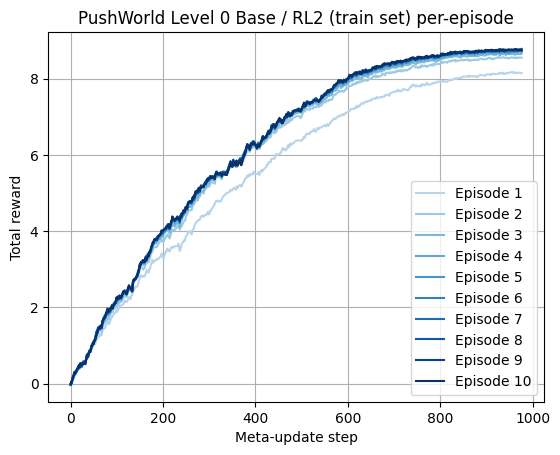

In [23]:
plot_per_episode(train_df)

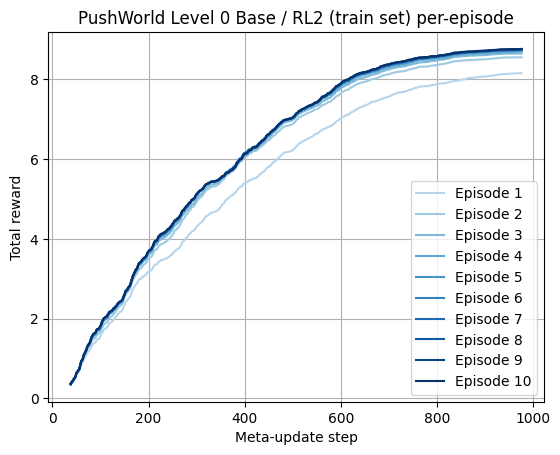

In [24]:
plot_per_episode(train_df, 20)

### Per-trial rewards (test set)¶


In [25]:
test_df = run.history(keys=[f"eval_test/episode_rewards/{i}" for i in range(config.eval_num_episodes)])

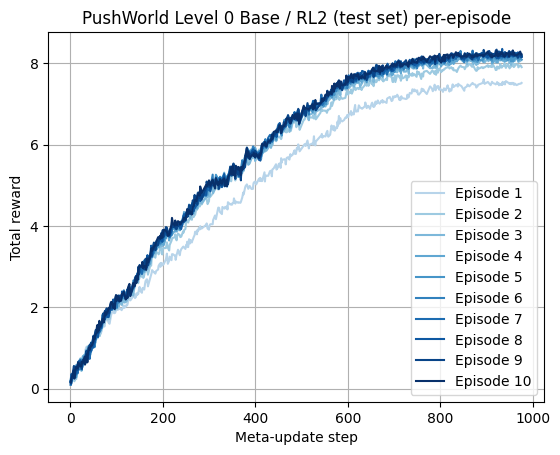

In [26]:
plot_per_episode(test_df, None, False)

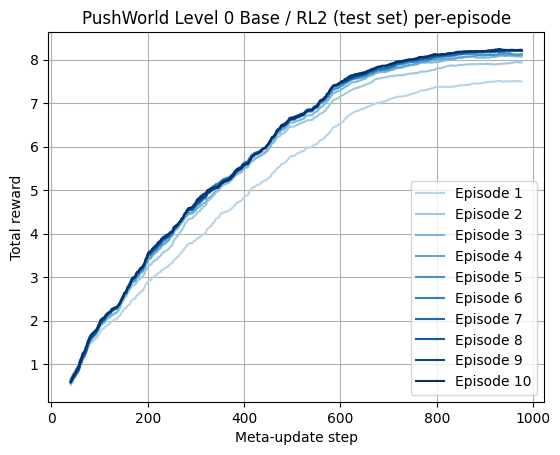

In [27]:
plot_per_episode(test_df, 20, False)